In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import h5py
import tqdm
import zipfile
from tqdm.notebook import tqdm_notebook
from progress.bar import IncrementalBar
import random
import pandas as pd
import time
import os
import math
from joblib import Parallel, delayed
# tf.config.run_functions_eagerly(True)
%matplotlib inline

In [2]:
param_names=['signal','pl_fr','real_wf-pl_fr','mask']

In [3]:
def norming(data,param_names=param_names,log=True):
    
    # ADD LOGARIFM FOR SIGNAL
    norm_params={}
    for i in range(data.shape[-1]):
        if (i==0 and log):
            data[:,:,:,i]=tf.math.log(data[:,:,:,i]+1)
        max_c=data[:,:,:,i].max()
        min_c=data[:,:,:,i].min()
        mean_c=data[:,:,:,i].mean()
        std_c=data[:,:,:,i].std()
        print(max_c,min_c)
        data[:,:,:,i]=(data[:,:,:,i]-min_c)/(max_c-min_c)

        norm_params[param_names[i]]=np.array([max_c,min_c])
    return norm_params
def renormin(data_not_change,norm_params,param_names=param_names,log=True):
    data=np.copy(data_not_change)
    for i in range(data.shape[-1]):
        max_c, min_c=norm_params[param_names[i]]
        data[:,:,:,i]=data[:,:,:,i]*(max_c-min_c) + min_c
        if (i==0 and log):
            data[:,:,:,i]=tf.math.exp(data[:,:,:,i])-1
        elif (i==1 or i==2):
            data[:,:,:,i]=data[:,:,:,i]*1e6
    return data

In [43]:
path='../../mc_hadrons_qgs34_0010.h5'
data_name='pr-q4-9yr'
data=np.zeros((1,6,6,4))
with h5py.File(path,'r') as f:
    data=np.concatenate((data,f[data_name]['dt'][:2000,:,:,3:7]))
    gp=f[data_name]['gp'].value
    ev_params=f[data_name]['ev_params'].value
data=data[1:]
data[:,:,:,1]=data[:,:,:,1]*1e6
data[:,:,:,2]=data[:,:,:,2]*1e6
print('len data: ',len(data))

len data:  2000


/home/rfit/.conda/envs/robert_venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/home/rfit/.conda/envs/robert_venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys


# Constant

In [44]:
pi = tf.constant(math.pi)
UNIT=1
dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
c=tf.constant(299792.458,dtype=tf.float32)# # km\s
NSEC= 1e6/c# in rubsov's code is a time for 1.2 km 1.2/c*1e9
R_L=30e-3
LINSLEY_r0=0.025
Det_Area=30
tf_type=tf.float32
s_min = tf.constant([[0.3]])
s_max = tf.constant([[1.8]])
t_err_res=c/1e6
t0_err=30

In [45]:
def reduce_saturation(data,ret_sig=True):
    max_signal=tf.reduce_max(data[:,:,:,0])
    signal=data[:,:,:,0]
    mask=data[:,:,:,3]
#     print('old signal \n',signal)
#     print('old mask \n',mask)
    new_mask=tf.where(tf.logical_and(mask!=0,signal==0),0,mask)
    new_signal=tf.where(tf.logical_and(mask!=0,signal==0),max_signal,signal)
    res=tf.where(tf.logical_and(mask!=0,signal==0),1,0)
    print(tf.reduce_sum(res))
    if ret_sig:
        return new_signal
    else:
        return new_mask

In [67]:
pi = tf.constant(math.pi)
UNIT=1
dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
c=tf.constant(299792.458,dtype=tf.float32)# # km\s
NSEC= 1e6/c# in rubsov's code is a time for 1.2 km 1.2/c*1e9
R_L=30e-3
LINSLEY_r0=0.025
Det_Area=30
tf_type=tf.float32
s_min = tf.constant([[0.3]])
s_max = tf.constant([[1.8]])
t_err_res=c/1e6
t0_err=30
class Reconstruction():
    #constants
    pi = tf.constant(math.pi)
    UNIT=1
    dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
    c=tf.constant(299792.458,dtype=tf.float32)# # km\s
    NSEC= 1e6/c# in rubsov's code is a time for 1.2 km 1.2/c*1e9
    R_L=30e-3
    LINSLEY_r0=0.025
    DET_AREA=3
    s_min = tf.constant([[0.3]])
    s_max = tf.constant([[1.8]])
    t_err_res=c/1e6
    t0_err=30
    dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
    
    def __init__(self,data,tf_type):
        # all have shape (batch,6,6,1)
        self.tf_type = tf_type
        self.data=tf.cast(data,self.tf_type)
        self.mask = tf.expand_dims(data[:,:,:,3],-1)
        self.signal = tf.expand_dims(data[:,:,:,0],-1)*self.mask
        self.mask = tf.where(self.signal==0,0,self.mask)
        self.real_time = tf.expand_dims((data[:,:,:,1] + data[:,:,:,2]),-1)*self.mask 
        self.signal = tf.cast(self.signal,self.tf_type)
        self.real_time = tf.cast(self.real_time,self.tf_type)
        self.mask = tf.cast(self.mask,self.tf_type)
        self.batch = data.shape[0]
        self.t0 = None
        self.theta = None
        self.detertors_coord = None
        self.core = None
        self.t_place = None
        self.courve = None
        self.R_error = 0.15
        self.S_X=None
        self.LDF=None
#     @classmethod
    def detectors_init(self):
        x = tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),0),6,axis=0),self.tf_type)
        y = tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),1),6,axis=1),self.tf_type)
        x = tf.expand_dims(x,-1)
        y = tf.expand_dims(y,-1)
        # x.shape = (6,6,1)
        detectors = tf.concat([x,y],axis=-1) * self.dist
        
        #detectors.shape = (batch,6,6,2) in km
        detectors = tf.repeat(tf.expand_dims(detectors,0),self.batch,0)
        self.detertors_coord=detectors
        return detectors
#     @classmethod
    def core_(self):
        detectors = self.detectors_init() # shape (batch,6,6,2)
        sum_signal=tf.reduce_sum(self.signal,axis=(1,2)) # shape (batch ,1)
        core=tf.reduce_sum(detectors * self.signal, axis=(1,2))/sum_signal
        #update self
        self.core = core
        return core
    @staticmethod
    def expand_dims(vec):
        return tf.expand_dims(tf.expand_dims(vec,-1),-1)
    def create_matrix(self,x,y,t,mask):
        a11=self.expand_dims(tf.reduce_sum(x*x,axis=1))
        a12=self.expand_dims(tf.reduce_sum(x*y,axis=1))
        a13=self.expand_dims(tf.reduce_sum(x,axis=1))
        a22=self.expand_dims(tf.reduce_sum(y*y,axis=1))
        a23=self.expand_dims(tf.reduce_sum(y,axis=1))
        a33=self.expand_dims(tf.reduce_sum(mask,axis=1))
        a1=tf.concat([a11,a12,a13],axis=2)
        a2=tf.concat([a12,a22,a23],axis=2)
        a3=tf.concat([a13,a23,a33],axis=2)
        A=tf.concat([a1,a2,a3],axis=1)

        b1=self.expand_dims(tf.reduce_sum(x*t,axis=1))
        b2=self.expand_dims(tf.reduce_sum(y*t,axis=1))
        b3=self.expand_dims(tf.reduce_sum(t,axis=1))
        b=tf.concat([b1,b2,b3],axis=1)
        return A,b
    def place_sol(self):
        real_time=self.real_time
        mask=self.mask
        detectors = self.detectors_init() * mask
        x = tf.reshape(detectors[:,:,:,0],(-1,36))
        y = tf.reshape(detectors[:,:,:,1],(-1,36))
        t = tf.reshape(real_time,(-1,36))
        mask = tf.reshape(mask,(-1,36))
        A,b=self.create_matrix(x,y,t,mask)
        return tf.linalg.solve(A,b)
#     @classmethod
    def place_params(self):
        sol = self.place_sol()
        #t_0=b+(r_cor;n)
        b=sol[:,2:,0]
        n=sol[:,:2,0]
        core = self.core_()
        mul=n[:,0]*core[:,0]+n[:,1]*core[:,1]
#         t0 = tf.cast(tf.expand_dims(b,1)+tf.expand_dims(mul,1),dtype=self.tf_type)
        t0=b
        a_x=n[:,0]
        a_y=n[:,1]
        a_z=tf.math.pow(1e6/c,2) - (tf.math.pow(a_x,2) + tf.math.pow(a_y,2))
        a_z=tf.where(a_z>0,tf.math.sqrt(a_z),0)
        cos_theta=a_z*(c/1e6)
        theta=tf.math.acos(cos_theta)
        tg_phi=a_x/(-a_y)
        atan=tf.math.atan(tg_phi)
        phi=tf.where(a_y>0,atan+pi,atan-pi)
        phi=tf.where(a_x<0,atan,phi)
        phi = tf.math.atan2( -a_x, -a_y )
        # update self
        self.phi = phi
        self.theta = theta
        self.t0=t0
        return t0,tf.expand_dims(theta,-1),tf.expand_dims(phi,-1)
    def detectors_core(self):
        detectors=self.detertors_coord
        core = self.core
        detectors_c=detectors-tf.reshape(core,(-1,1,1,2))
        return detectors_c
#     @classmethod
    def place_reconstruction(self):
        t0,theta,phi = self.place_params()
        detectors = self.detectors_core()
        detectors = self.detertors_coord
#         print(detectors)
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)*(1e6/c)
#         print(n)
        t_place =  t0 + detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        t_place = t_place*self.mask
        self.t_place = t_place*self.mask
        return self.t_place
    def place_reconstruction_static(self,t0,theta,phi):
        detectors = self.detectors_core()
        detectors = self.detertors_coord
#         print(detectors)
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)*(1e6/c)
#         print(n)
        t_place =  t0 + detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        t_place = t_place*self.mask
        self.t_place = t_place*self.mask
        return self.t_place
    @staticmethod
    def eta_fun(theta):
        x=theta*180/3.14

        e1 = 3.97 - 1.79*(tf.math.abs(1.0/tf.math.cos(theta)) - 1.0)
        e2 = ((((((-1.71299934e-10*x + 4.23849411e-08)*x -3.76192000e-06)*x
                   + 1.35747298e-04)*x -2.18241567e-03)*x + 1.18960682e-02)*x
                 + 3.70692527e+00)
        res = tf.where(x<62.7,e1,e2)
        # check
        res =tf.where(res>0,res,0)
        return res
    def s_profile_tasimple(self,r_ta,theta):
        r = r_ta*UNIT
        eta=self.eta_fun(theta)# batch,1,1
        eta=tf.repeat(eta,6,axis=1)
        eta=tf.repeat(eta,6,axis=2)
        # eta shape is batch,6,6
        Rm = tf.constant(0.09,dtype=tf.float32)
        R1 = tf.constant(1,dtype=tf.float32)
        return (tf.math.pow((r/Rm),-1.2)*tf.math.pow((1+r/Rm), -(eta-1.2))*tf.math.pow(1+(tf.math.pow(r,2)/R1/R1),-0.6))
    def s_profile(self,r_ta, theta):
        #r_ta shape batch,6,6
        f800=self.s_profile_tasimple(self.expand_dims(tf.constant(0.8)), theta)
        return self.s_profile_tasimple(r_ta, theta)/f800
    def pfs__pps(self):
        t0,theta,phi = self.place_params()
        # u can read from t_place if in place_reconstruction use core shift
        detectors = self.detectors_core()
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
        t_place = detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2] # not has t0
        # end t_place's part
        dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
        dist_core = tf.where(dist_core>0,tf.math.sqrt(dist_core),0)
        cond_dist = tf.cast(tf.where(tf.logical_and(dist_core>s_min,dist_core<s_max),self.mask,0.),tf_type)
        pfs = tf.reduce_sum(self.signal*cond_dist,axis=(1,2))
        pps = tf.reduce_sum(self.s_profile(dist_core,theta)*cond_dist,axis=(1,2))
        # might update self
        return (pfs,pps)
    @staticmethod
    def a_ivanov_fun(theta):
        DEG=pi/180
        threshold1=25*DEG
        threshold2=35*DEG
        # переписать для обнавления масива
        res1=tf.where(theta<threshold1,3.3836 - 0.01848*theta/DEG,0)
        res3=tf.where(theta>threshold2,tf.math.exp(-3.2e-2*theta/DEG + 2.0),0)
        a=(0.6511268210e-4*(theta/DEG-0.2614963683))*(theta/DEG*theta/DEG-134.7902422*theta/DEG+4558.524091)
        res2=tf.where(tf.math.logical_and(theta > threshold1,theta < threshold2),a,0)
        return res1+res2+res3
    
    def courve_fun(self):
        a_ivanov = self.a_ivanov_fun(self.theta)
        pfs,pps = self.pfs__pps()
        # norming
        S_X = tf.where(pps>1e-10,pfs/pps,1)[:,0]
        self.S_X=tf.expand_dims(S_X,-1)
        courve = tf.expand_dims(a_ivanov*1.3/tf.math.sqrt(S_X),axis=-1)
        self.courve = courve
        return courve
    @staticmethod
    def linsley_t(r,S):
        return 0.67*tf.math.pow((1 + r/LINSLEY_r0), 1.5)*tf.math.pow(S, -0.5)/1e3
    def courve_reconstruction(self):
        t0,theta,phi = self.place_params()
        # u can read from t_place if in place_reconstruction use core shift
        detectors = self.detectors_core()
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
        t_place = detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
        dist_core = tf.where(dist_core>0,tf.math.sqrt(dist_core),0)
        LDF=self.s_profile(dist_core,theta)
        self.LDF=LDF
        td=self.expand_dims(self.courve)*self.linsley_t(dist_core,LDF)/NSEC
        return td
    def courve_reconstruction_static(self,t0,theta,phi,courve):
        t0,theta,phi = self.place_params()
        # u can read from t_place if in place_reconstruction use core shift
        detectors = self.detectors_core()
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
        t_place = detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
        # add R-error
        dist_core = tf.where(dist_core>self.R_error*self.R_error,tf.math.sqrt(dist_core),self.R_error)
        cond_dist = tf.cast(tf.where(tf.logical_and(dist_core>s_min,dist_core<s_max),self.mask,0.),tf_type)
        LDF=self.s_profile(dist_core,theta)#*cond_dist
        self.LDF=LDF
        td=self.expand_dims(courve)*self.linsley_t(dist_core,LDF)/NSEC
        return td,LDF
    @staticmethod
    def logPua(n,nbar):
        print(n.shape,nbar.shape)
        last_part = 2*(n*tf.math.log(nbar/(n+1e-8)) + (n - nbar))

        nbar_logical=tf.where(nbar < 1e-90,True,False)
        n_logical1 = tf.where(n>1e-90,True,False)
        res = tf.zeros_like(n)
        res=tf.where(tf.logical_and(nbar_logical,n_logical1),-1e-6,res)

        else_nbar_logical = tf.logical_not(nbar_logical) 
        n_logical2 = tf.where(n<1e-20,True,False)

        res=tf.where(tf.logical_and(else_nbar_logical,n_logical2),-2*nbar,res)
        res=tf.where(tf.logical_and(else_nbar_logical,tf.logical_not(n_logical2)),last_part,res)
        return res
    def chi2L(self,S_X,s_prof):
        mask=self.mask
        s_fit = self.expand_dims(S_X)*s_prof*mask
        qs=self.signal
#         print('signal',(s_fit)[9])
        s_sigma2 = ( 2*qs/self.DET_AREA + tf.math.pow( 0.15*qs, 2 ) + 1e-6 )
        maskL2 = tf.where(s_fit>4.0,mask,0)
        S=S_X
        chi2L2=tf.reduce_sum((qs - s_fit)*(qs - s_fit)/s_sigma2*maskL2,axis=(1,2))
        maskL3 = tf.where(s_fit<4.0,mask,0)
#         chi2L3 = -tf.reduce_sum(0.4*self.logPua(S*self.DET_AREA, s_fit*self.DET_AREA)*maskL3,axis=(1,2))
#         print(chi2L2.shape,chi3L.shape)
        return chi2L2  #+ chi3L
    def optimization(self,iterats,alpha=0.1):
        # add ch2_L
        self.detectors_init()
        self.core_()
        self.place_sol()
        # ??? don't work without that 
        pfs,pps= rec.pfs__pps()
        rec.courve_fun()
        chi_list=[]
        self.place_params()
        t0=self.t0
        theta=tf.expand_dims(self.theta,-1)
        phi=tf.expand_dims(self.phi,-1)
        core = self.core
        courve= self.courve
        S_X = self.S_X # tf.math.log(
        # ыделать через salf
        params=tf.concat([t0,theta,phi,courve,core,S_X],axis=1)
        params_list=[]
        params_list.append(params)
        for i in range(iterats):
            with tf.GradientTape() as gr:  
                gr.watch(params)
                self.t0=params[:,0:1]
                self.theta=params[:,1:2]
                self.phi=params[:,2:3]
                self.courve=params[:,3:4]
                self.core=params[:,4:6]
                self.S_X=params[:,6:7]
                
                t0=params[:,0:1]
                theta=params[:,1:2]
                phi=params[:,2:3]
                courve=params[:,3:4]
                S_X=params[:,6:7]
#                 print(i,S_X)
                t_place = self.place_reconstruction_static(t0,theta,phi)
                td,LDF = self.courve_reconstruction_static(t0,theta,phi,courve)  #update LDF <==> s_profile
                t_sigma2=(t0_err*t0_err + td*td) * t_err_res
                time_reco = t_place +td
                chi_T=tf.reduce_sum(tf.math.pow((time_reco-self.real_time)*self.mask,2)/t_sigma2,axis=(1,2))
                chi_L=self.chi2L(S_X,LDF) #tf.math.log(
                chi = chi_T +chi_L
                print(tf.reduce_mean(chi_L),tf.reduce_mean(S_X))
                chi_list.append(chi)
                grad=gr.gradient(chi,params)
#                 print(grad)
                params=params-alpha*grad
                # updating
                self.t0=params[:,0:1]
                self.theta=params[:,1:2]
                self.phi=params[:,2:3]
                self.courve=params[:,3:4]
                self.core=params[:,4:]
                self.S_X=params[:,6:7]
                params_list.append(params)
        return np.array(chi_list),np.array(params_list)

In [68]:
rec = Reconstruction(data[:20],tf.float32)
# det=rec.detectors_init()
# core=rec.core_()
# sol = rec.place_sol() 
# sol
chi,params=rec.optimization(1000,alpha=0.1)

tf.Tensor(25153.738, shape=(), dtype=float32) tf.Tensor(5.9452424, shape=(), dtype=float32)
tf.Tensor(2.589143, shape=(), dtype=float32) tf.Tensor(-417.68442, shape=(), dtype=float32)
tf.Tensor(2.0117574, shape=(), dtype=float32) tf.Tensor(-417.85733, shape=(), dtype=float32)
tf.Tensor(1.3590698, shape=(), dtype=float32) tf.Tensor(-417.9754, shape=(), dtype=float32)
tf.Tensor(1.2081769, shape=(), dtype=float32) tf.Tensor(-418.0377, shape=(), dtype=float32)
tf.Tensor(1.0967572, shape=(), dtype=float32) tf.Tensor(-418.08438, shape=(), dtype=float32)
tf.Tensor(1.0108645, shape=(), dtype=float32) tf.Tensor(-418.12085, shape=(), dtype=float32)
tf.Tensor(0.94326717, shape=(), dtype=float32) tf.Tensor(-418.1503, shape=(), dtype=float32)
tf.Tensor(0.8894881, shape=(), dtype=float32) tf.Tensor(-418.17465, shape=(), dtype=float32)
tf.Tensor(0.8464383, shape=(), dtype=float32) tf.Tensor(-418.19522, shape=(), dtype=float32)
tf.Tensor(0.811848, shape=(), dtype=float32) tf.Tensor(-418.21274, shape=(

tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-41

tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-41

tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-41

tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-41

tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-41

tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-41

tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-41

tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-41

tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-41

tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-418.26993, shape=(), dtype=float32)
tf.Tensor(0.61743385, shape=(), dtype=float32) tf.Tensor(-41

In [48]:
rec.theta.shape
# data[:2000].shape

TensorShape([2000, 1])

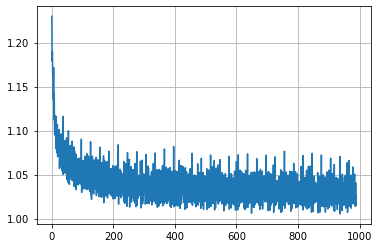

In [49]:
plt.plot(tf.reduce_mean(chi[10:,:,0],axis=1))
plt.grid()

(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)


Text(0.5, 1.0, 'chi_T')

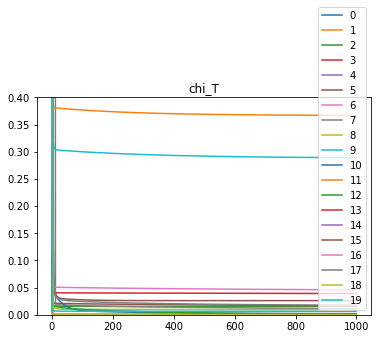

In [50]:
for i in range(20):
    print(np.array(chi).shape)
    plt.plot(chi[:,i,0],label=str(i))
    plt.ylim(0,0.4)
plt.legend()
plt.title('chi_T')

(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)


Text(0.5, 1.0, 'S_X')

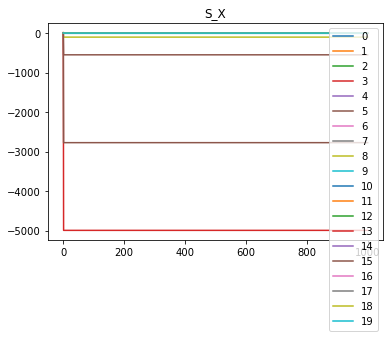

In [51]:
for i in range(0,20):
    print(np.array(chi).shape)
    plt.plot(params[:,i,-1],label=str(i))
plt.legend()
plt.title('S_X')

(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)
(1000, 2000, 1)


Text(0.5, 1.0, 't0')

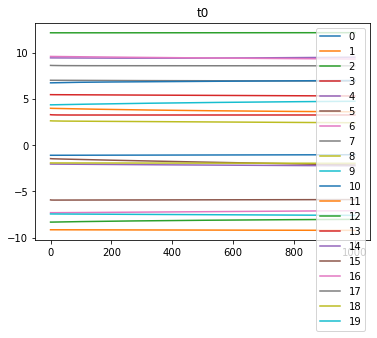

In [52]:
for i in range(20):
    print(np.array(chi).shape)
    plt.plot(params[:,i,0],label=str(i))
plt.legend()
plt.title('t0')

In [53]:
theta_r = ev_params[20:40,2]/180*math.pi


Text(0.5, 1.0, 'theta')

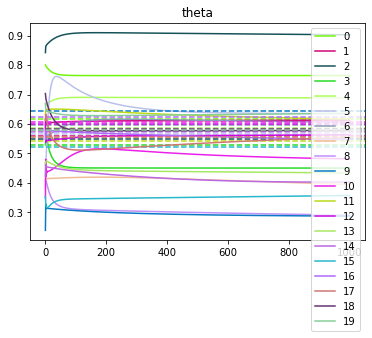

In [54]:
for i in range(20):
    c=np.random.rand(3)
    plt.plot(params[:,i,1],label=str(i),c=c)
    plt.axhline(y = theta_r[i], color =c, linestyle = '--') 
plt.legend()
plt.title('theta')

Text(0.5, 1.0, 'phi')

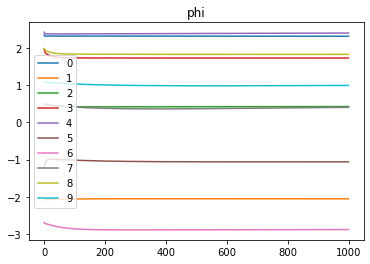

In [55]:
for i in range(10):
    plt.plot(params[:,i,2],label=str(i))
plt.legend()
plt.title('phi')

(1001, 2000, 7)
(1001, 2000, 7)
(1001, 2000, 7)
(1001, 2000, 7)
(1001, 2000, 7)
(1001, 2000, 7)
(1001, 2000, 7)
(1001, 2000, 7)
(1001, 2000, 7)
(1001, 2000, 7)


Text(0.5, 1.0, 'courve')

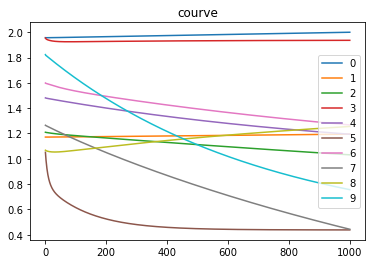

In [56]:
for i in range(10):
    print(params[:].shape)
    plt.plot(params[:,i,3],label=str(i))
plt.legend()
plt.title('courve')

In [57]:
ev_params[20:40,2:4] 

array([[ 35.3505 , 110.117  ],
       [ 32.0455 , 332.741  ],
       [ 31.4524 , 334.699  ],
       [ 30.2315 , 294.016  ],
       [ 33.0698 , 253.295  ],
       [ 32.457  , 301.215  ],
       [ 34.105  , 138.855  ],
       [ 31.8346 ,   8.54537],
       [ 32.7883 , 283.106  ],
       [ 36.9185 , 230.656  ],
       [ 34.8607 , 108.764  ],
       [ 31.14   , 171.404  ],
       [ 34.4091 , 322.173  ],
       [ 33.5278 ,   4.13313],
       [ 33.0801 , 181.94   ],
       [ 29.9834 ,  74.079  ],
       [ 35.8023 , 293.769  ],
       [ 31.876  ,  25.2436 ],
       [ 33.4199 , 263.276  ],
       [ 33.2462 , 216.394  ]], dtype=float32)

In [58]:
ang_res=tf.concat([rec.theta*180/3.14,tf.where(rec.phi*180/3.14>0,rec.phi*180/3.14,(rec.phi+3.14*2)*180/3.14)],axis=1)
ang_res.shape

TensorShape([2000, 2])

In [50]:
#Befor chi_L
diff= tf.reduce_mean(tf.math.abs(ev_params[20:40,2:4] -ang_res),axis=0)
print(diff)
print(tf.math.reduce_std(ev_params[20:40,2] -ang_res[:,0]),tf.math.reduce_std(ev_params[20:40,3] -ang_res[:,1]))

tf.Tensor([ 6.708931 14.361145], shape=(2,), dtype=float32)
tf.Tensor(9.405685, shape=(), dtype=float32) tf.Tensor(22.320835, shape=(), dtype=float32)


In [59]:
# after
diff= tf.reduce_mean(tf.math.abs(ev_params[:2000,2:4] -ang_res),axis=0)
print(diff)
print(tf.math.reduce_std(ev_params[:2000,2] -ang_res[:,0]),tf.math.reduce_std(ev_params[:2000,3] -ang_res[:,1]))

tf.Tensor([ 7.682284 30.26008 ], shape=(2,), dtype=float32)
tf.Tensor(13.246112, shape=(), dtype=float32) tf.Tensor(75.840805, shape=(), dtype=float32)


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  5.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.

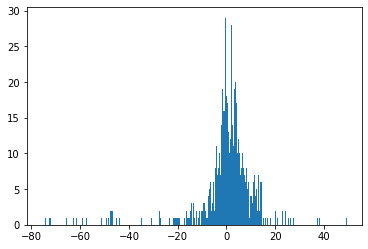

In [63]:
plt.hist(ev_params[:2000,2] -ang_res[:,0],bins=1000)

In [3]:
num = 64
h5f = '../../mc_hadrons_qgs34_0010.h5'
h5f = '/home3/ivkhar/TA/data/mass_spectrum/old_1223/hadrons/bundled/mc_hadrons_qgs34_0010.h5'
with h5py.File(h5f,'r') as hf:
    times_flat = hf['pr-q4-9yr/dt'][:num,:,:,4:5]*1e6 # in mks
    times_diff = hf['pr-q4-9yr/dt'][:num,:,:,5:6]*1e6 # in mks
    mask = hf['pr-q4-9yr/dt'][:num,:,:,6:7]
    real_coords = hf['pr-q4-9yr/dt'][:num,:,:,:3] # in 1.2*km
    qs = hf['pr-q4-9yr/dt'][:num,:,:,3:4]
    ev_params = hf['pr-q3-9yr/ev_params'][:num]
    
times_reg = times_flat + times_diff
mask_qs = tf.where( tf.math.logical_and(mask>0, qs>0), 1., 0. )
xs = tf.expand_dims( tf.linspace( 0., 5*1.2, 6 ), axis=-1 )
xs = tf.repeat(xs, 6, axis=1)
ys = tf.transpose( xs )
coords = tf.expand_dims( tf.stack( (xs,ys), axis=-1 ), axis=0 ) # in km
c = tf.constant(0.299792458, dtype=tf.float32) # in km\mks
# prepare matricies to solve
def make_matrix(coords, times_reg, mask):
    
    # matrix for dL/db
    hs = tf.ones((1,6,6,1)) # to make (x_1,x_2) -> (x_1,x_2,1), to account for b
    coords_ext = mask*tf.concat( (coords,hs), axis=-1 ) # (bs,6,6,3)
    matrix_b = tf.expand_dims( tf.math.reduce_sum( coords_ext, axis=(1,2) ), axis=-1 ) # (bs,6,6,3,1)
    times = mask*times_reg # (bs,6,6,1)
    rhs_b = tf.math.reduce_sum( times, axis=(1,2) ) # (bs,1)
    
    # matrix for dL/da
    coords_mul = tf.expand_dims( coords_ext, axis=-1) * tf.expand_dims( coords, axis=-2)
    matrix_a = tf.math.reduce_sum( coords_mul, axis=(1,2) ) # (bs,6,6,3,2)
    ts_mul = times * coords
    rhs_a = tf.math.reduce_sum( ts_mul, axis=(1,2) )
    
    matrix = tf.concat((matrix_b,matrix_a), axis=-1)
    rhs = tf.expand_dims( tf.concat((rhs_b,rhs_a), axis=-1), axis=-1 )
    
    return matrix, rhs
def lin_solve(matrix, rhs):
    sol_flat = tf.linalg.solve( matrix, rhs, adjoint=True )[:,:,0]
    print(sol_flat)
    t0 = sol_flat[:,2]
    # extract parameters
    n_z = 1/c/c - tf.math.reduce_sum(sol_flat[:,:2]*sol_flat[:,:2], axis=1)
    n_z = tf.where( n_z>0, tf.math.sqrt( n_z ), 0. ) # some configurations yield front moving faster than light
    print('n_z',n_z)
    theta_flat = tf.math.acos( n_z*c )
    phi_flat = tf.math.atan2( sol_flat[:,1], sol_flat[:,0] )
    
    return theta_flat, phi_flat, t0
matrix, rhs = make_matrix(coords, times_reg, mask)
sol_flat=lin_solve(matrix, rhs)
theta, phi, t0 = lin_solve(matrix, rhs) # (bs,)
phi/3.14*180


tf.Tensor(
[[  1.690568    -1.6945748   -1.0818156 ]
 [  0.9904436    1.678957    -9.411423  ]
 [ -2.192621    -1.1778892   12.180873  ]
 [  0.66441846  -1.5473608    3.3125598 ]
 [  1.5665901   -1.3564273   -2.033852  ]
 [ -0.50638616   1.4255589   -5.9170237 ]
 [  1.693558     0.80760324  -7.2979884 ]
 [ -1.1613629   -0.44394162   7.119641  ]
 [  0.539285    -1.2119058    2.6467204 ]
 [ -0.36687446  -0.6997201    4.3824077 ]
 [ -0.8971767   -0.7005648    6.763143  ]
 [  0.8620558   -1.7710629    4.004331  ]
 [  1.486538     1.1685897   -8.332845  ]
 [  0.44323626  -1.4122609    5.4817886 ]
 [ -1.2110292   -0.6453041    9.464282  ]
 [ -0.47500038   1.054167    -1.446     ]
 [ -1.126339    -1.322737     9.62021   ]
 [ -1.9163822    0.02383728   8.648997  ]
 [ -0.8919314    1.9643096   -1.9128022 ]
 [  0.8607137    1.9327376   -7.716711  ]
 [  0.58633155  -1.741169     4.4970164 ]
 [ -1.4055791    0.8666418    3.4287083 ]
 [ -1.594655     1.0198795    2.3299828 ]
 [ -0.32000008   0.8293

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ -45.090675 ,   59.493122 , -151.83202  ,  -66.795746 ,
        -40.908295 ,  109.61158  ,   25.507902 , -159.16087  ,
        -66.04494  , -117.72843  , -142.08736  ,  -64.07822  ,
         38.190773 ,  -72.61241  , -152.02588  ,  114.31395  ,
       -130.48126  ,  179.37828  ,  114.47934  ,   66.028435 ,
        -71.42547  ,  148.41838  ,  147.47336  ,  111.154564 ,
         99.09006  ,  111.39848  ,  -38.16081  , -173.6324   ,
        152.98344  ,   44.788975 ,  -45.31987  ,  -15.201984 ,
        138.35306  , -160.82552  ,   20.068356 ,  -95.30713  ,
         71.44137  , -154.94284  ,  107.48643  ,   48.002686 ,
          4.0393744,  -55.981457 ,  133.64186  , -174.19273  ,
         71.1309   ,  130.7888   ,  116.42755  ,  -37.481594 ,
         11.4989195,   85.55882  ,    1.0422605,  138.42151  ,
         57.84859  , -141.22237  ,   13.51256  ,  -13.543718 ,
       -105.87633  ,  178.18668  , -165.66962  ,  -29.445803 ,
        

In [162]:
sol[:2]

<tf.Tensor: shape=(2, 3, 1), dtype=float32, numpy=
array([[[-1.6945673 ],
        [ 1.690574  ],
        [-1.0818663 ]],

       [[ 1.6789589 ],
        [ 0.99045706],
        [-9.411484  ]]], dtype=float32)>

In [160]:
t0_ext = t0[:,tf.newaxis,tf.newaxis]
nx = 1/c*tf.math.sin(theta)[:,tf.newaxis,tf.newaxis] * tf.math.cos(phi)[:,tf.newaxis,tf.newaxis]
ny = 1/c*tf.math.sin(theta)[:,tf.newaxis,tf.newaxis] * tf.math.sin(phi)[:,tf.newaxis,tf.newaxis]
a = tf.concat((nx,ny), axis=-1)
a = tf.expand_dims( a, axis=1 )

t_rec = t0_ext + tf.math.reduce_sum( a*coords, axis=-1 )
t_rec = t_rec*mask[:,:,:,0]
times_flat[:,:,:,0]*mask[:,:,:,0]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -3.593     ,
         -5.576     ,  0.        ],
        [ 0.        ,  0.        ,  0.325     , -1.714     ,
         -3.748     ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -0.125     ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  3.8920002 ,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -1.665     ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -2.3170002 , -0.62      ,
          1.778     ,  0.        ],
        [ 0.        ,  0.   